# Benchmark

## Imports

## If the pkl files are not present you can download them from this AWS bucket

In [19]:
import boto3
s3 = boto3.resource("s3",endpoint_url = 'https://'+'minio.lab.sspcloud.fr',
                  aws_access_key_id= 'BLGPRQYFIH2BU8J9NYTS', 
                  aws_secret_access_key= '2+uxJ68MKTvkIgHM7OS+MIP9E80rgXPuKNW6GWp+', 
                  aws_session_token = 'eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJCTEdQUlFZRklIMkJVOEo5TllUUyIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNjc3NzcyODU4LCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6Imx1Y2FzLnNhYmFuQGVuc2FlLmZyIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImV4cCI6MTY3Nzg1OTI2MCwiZmFtaWx5X25hbWUiOiJTYWJhbiIsImdpdmVuX25hbWUiOiJMdWNhcyIsImdyb3VwcyI6W10sImlhdCI6MTY3Nzc3Mjg1OSwiaXNzIjoiaHR0cHM6Ly9hdXRoLmxhYi5zc3BjbG91ZC5mci9hdXRoL3JlYWxtcy9zc3BjbG91ZCIsImp0aSI6ImUwMDZjN2YyLTY1Y2UtNGZhZS05MDBhLTZmNGFiOGRmMTE0MCIsIm5hbWUiOiJMdWNhcyBTYWJhbiIsIm5vbmNlIjoiMzVkMzJlMzMtYjI4ZS00OTZkLTkzMGMtYzc0MTFjYWRkNjUyIiwicG9saWN5Ijoic3Rzb25seSIsInByZWZlcnJlZF91c2VybmFtZSI6ImxzYWJhbiIsInJlYWxtX2FjY2VzcyI6eyJyb2xlcyI6WyJvZmZsaW5lX2FjY2VzcyIsInVtYV9hdXRob3JpemF0aW9uIiwiZGVmYXVsdC1yb2xlcy1zc3BjbG91ZCJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoib3BlbmlkIHByb2ZpbGUgZ3JvdXBzIGVtYWlsIiwic2Vzc2lvbl9zdGF0ZSI6ImU1M2JjZDUzLTk3NzctNDIwNS1iNTFjLWIxMjczMGM1NWM4MiIsInNpZCI6ImU1M2JjZDUzLTk3NzctNDIwNS1iNTFjLWIxMjczMGM1NWM4MiIsInN1YiI6IjY5MmRmMDBjLWZlNmMtNDc4OS04ZGM0LTk5NWMxYWE4NzIyNyIsInR5cCI6IkJlYXJlciJ9.B7gxxbtxM_JB4NmGqn2gz9ebUDBgEfD5_MtO77qcUiR-jnJChKbWJTRsB30IbSJ2HgerbOf-n4Dby_ODD_TEEQ')
bucket = s3.Bucket('lsaban')

In [20]:
#to load files from bucket
for obj in bucket.objects.all():
    if not obj.key.endswith('.keep') and not os.path.exists('../'+obj.key):
        bucket.Object(obj.key).download_file('../'+obj.key)

# To load file to bucket
# for obj_key in [el for el in os.listdir('../nlp_data') if 'raw' in el.split('_')]:
#     bucket.upload_file(f'../nlp_data/{obj_key}', f'nlp_data/{obj_key}')

## Python Libs imports

In [1]:
import sys
import os 

sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

In [2]:
import pickle

import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from src import AI_IRW, OODDetector

sns.set_style('white')
from sklearn.metrics import average_precision_score, roc_auc_score

## Data loading and formatting

In [3]:
with open('../nlp_data/embeddings_raw_imbd_train.pkl', 'rb') as f:
    embd_train = pickle.load(f)

with open('../nlp_data/logits_imdb_train.pkl', 'rb') as f:
    logit_train = pickle.load(f)

with open('../nlp_data/attns_imdb_train.pkl', 'rb') as f:
    attn_train = pickle.load(f)

In [4]:
embd_ood = []
logit_ood = []
attn_ood = []
ood_dict = {}

for fn in [el for el in os.listdir('../nlp_data') if el.startswith('embeddings_raw_ood_test_')]:

    _name = fn.split('_')[-1].split('.')[0]
    _vars = {}

    with open('../nlp_data/'+fn, 'rb') as f:
        _embd = pickle.load(f)
    embd_ood += _embd

    _vars['embd'] = _embd

    with open(f"../nlp_data/logits_ood_test_{_name}.pkl", 'rb') as f:
        _logit = pickle.load(f)
    logit_ood += _logit

    _vars['logit'] = _logit

    with open(f"../nlp_data/attns_ood_test_{_name}.pkl", 'rb') as f:
        _attn = pickle.load(f)
    attn_ood += _attn

    _vars['attn'] = _attn   

    ood_dict[_name] = _vars 

In [5]:
with open('../nlp_data/embeddings_raw_imdb_test.pkl', 'rb') as f:
    embd_test = pickle.load(f)

with open('../nlp_data/logits_imdb_test.pkl', 'rb') as f:
    logit_test = pickle.load(f)

with open('../nlp_data/attns_imdb_test.pkl', 'rb') as f:
    attn_test = pickle.load(f)

In [6]:
logit_train = torch.cat(logit_train).numpy()
attn_train = torch.cat(attn_train).numpy()
embd_train = torch.cat(embd_train).numpy()

embd_train_distrib  = {l: embd_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}
attn_train_distrib  = {l: attn_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}
logit_train_distrib  = {l: logit_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}

In [7]:
logit_test = torch.cat(logit_test).numpy()
embd_test = torch.cat(embd_test).numpy()
attn_test = torch.cat(attn_test).numpy()


embd_test_distrib  = {l: embd_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}
attn_test_distrib  = {l: attn_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}
logit_test_distrib  = {l: logit_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}



In [8]:

# Aggregated
logit_ood = torch.cat(logit_ood).numpy()
embd_ood = torch.cat(embd_ood).numpy()
attn_ood = torch.cat(attn_ood).numpy()

embd_ood_distrib  = {l: embd_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}
attn_ood_distrib  = {l: attn_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}
logit_ood_distrib  = {l: logit_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}



#Per OOD-DS
for el in ood_dict.values():
    for _k, _v in el.items():
       el[_k] = torch.cat(_v).numpy()
        
    el['embd_ood_distrib']  = {l: el['embd'][np.where(np.argmax(el['logit'], axis=-1)==l)] for l in range(el['logit'].shape[1])}
    el['attn_ood_distrib']  = {l: el['attn'][np.where(np.argmax(el['logit'], axis=-1)==l)] for l in range(el['logit'].shape[1])}
    el['logit_ood_distrib']  = {l: el['logit'][np.where(np.argmax(el['logit'], axis=-1)==l)] for l in range(el['logit'].shape[1])}

    




In [9]:
X_0_embd =  np.concatenate((embd_ood_distrib[0], embd_test_distrib[0]))
X_0_attn =  np.concatenate((attn_ood_distrib[0], attn_test_distrib[0]))
y_0 =   np.concatenate((np.ones((embd_ood_distrib[0].shape[0])), np.zeros((embd_test_distrib[0].shape[0]))))

X_1_embd =  np.concatenate((embd_ood_distrib[1], embd_test_distrib[1]))
X_1_attn =  np.concatenate((attn_ood_distrib[1], attn_test_distrib[1]))
y_1 =   np.concatenate((np.ones((embd_ood_distrib[1].shape[0])), np.zeros((embd_test_distrib[1].shape[0]))))

X_embd = np.concatenate((logit_ood, logit_test))
X_attn = np.concatenate((attn_ood, attn_test))
y_ = np.concatenate((np.ones(logit_ood.shape[0]), np.zeros(logit_test.shape[0])))

## Benchmark of classifier

### If prediction dependent

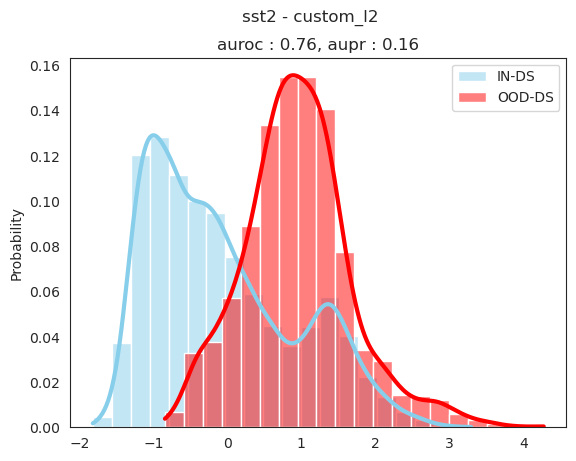

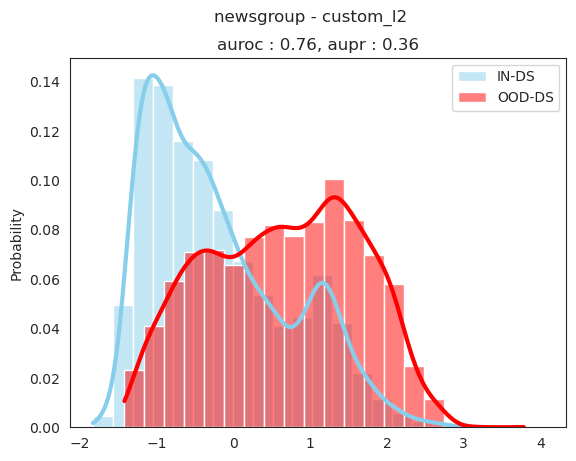

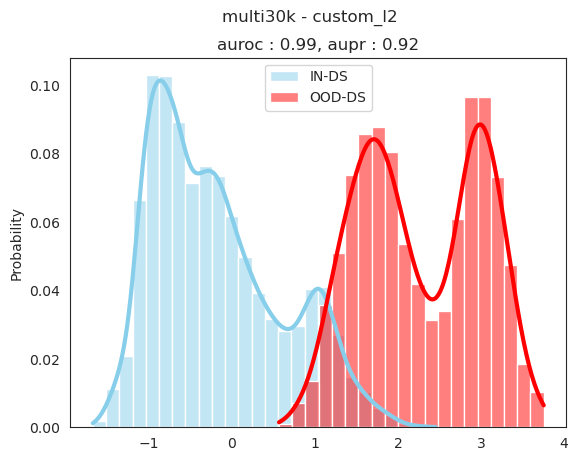

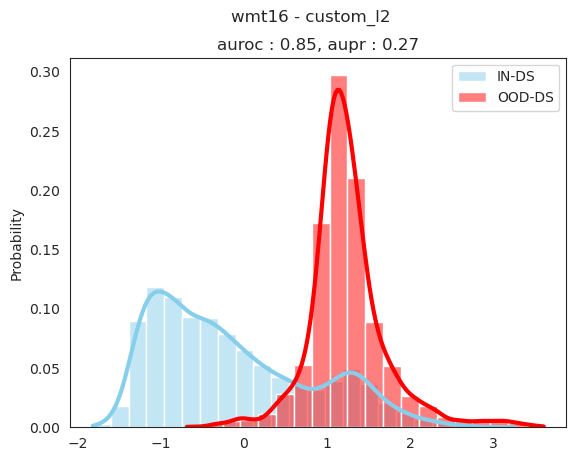

 Weighted mean [0.8456585  0.47625572]
Mean [0.8408612  0.43063864]


In [11]:
clfs = {
    i: OODDetector(
        similarity='custom_l2',
        base_distribution=embd_train_distrib[i],
        base_ood_distribution = ood_dict['newsgroup']['embd_ood_distrib'][i],
        T=10,
        sampling_ratio=.1,
     )
     .fit() for i in [0,1]
}
# Careful to change the embd/logits/embd according to the classifier

scores=[]
weights=[]
for ds_n,ood_ds in ood_dict.items():
    y_score_tot = []
    y_true_tot = []
    score_for_1__ds = []
    for i in [0,1]:
        clf = clfs[i]
        y_true = np.concatenate((np.ones(ood_ds['embd_ood_distrib'][i].shape[0]), np.zeros(embd_test_distrib[i].shape[0])))
        X = np.concatenate((ood_ds['embd_ood_distrib'][i] ,embd_test_distrib[i]))
        y_score = clf.predict_proba(X).flatten()
        auc_score = roc_auc_score(y_true=y_true, y_score=y_score)
        aupr = average_precision_score(y_true=y_true, y_score=y_score)
        scores.append([auc_score, aupr])
        score_for_1__ds.append([auc_score, aupr])
        y_score_tot.append((y_score - np.mean(y_score))/np.std(y_score))
        y_true_tot.append(y_true)
        weights.append(len(y_true))


    y_score_tot = np.concatenate(y_score_tot)
    y_true_tot = np.concatenate(y_true_tot)


    
    bins_width = (np.histogram(y_score_tot[y_true_tot==1])[1][3]-np.histogram(y_score_tot[y_true_tot==1])[1][2])/2
    sns.histplot(y_score_tot[y_true_tot==0], label='IN-DS', kde=True, stat='probability', color='skyblue', binwidth=bins_width, line_kws={"lw":3})
    sns.histplot(y_score_tot[y_true_tot==1], label='OOD-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3})
    _a = np.mean(score_for_1__ds, axis=0)
    plt.title(f"auroc : {_a[0]:.2f}, aupr : {_a[1]:.2f}")

    plt.suptitle(ds_n + f' - {clfs[0].similarity}')
    plt.legend()
    plt.savefig(f'../figures/{clfs[0].similarity}_{ds_n}.png')
    plt.show()

scores, weights = np.array(scores), np.array(weights)/(np.sum(weights))
print(f" Weighted mean {scores.T@weights}")
print(f"Mean {np.mean(scores, axis=0)}")
    

### for the rest

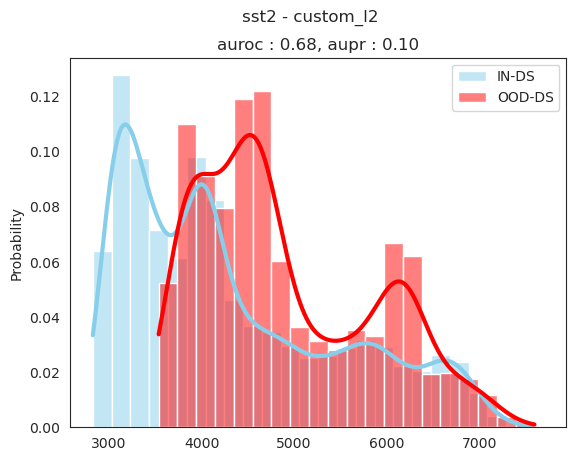

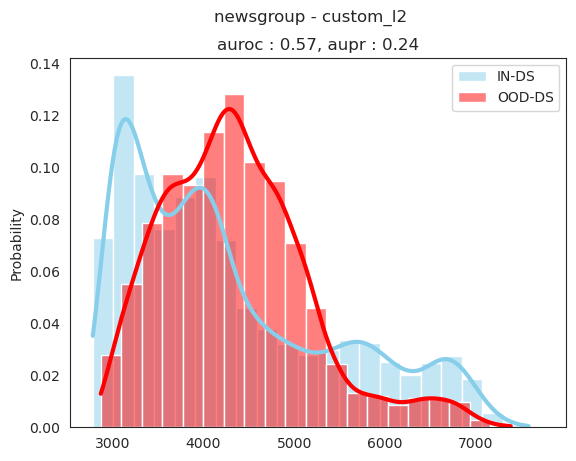

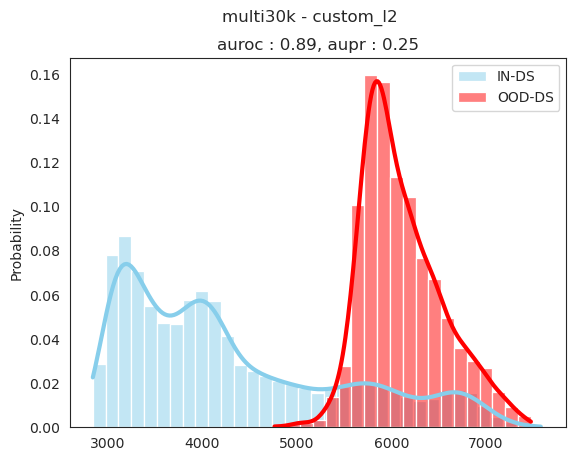

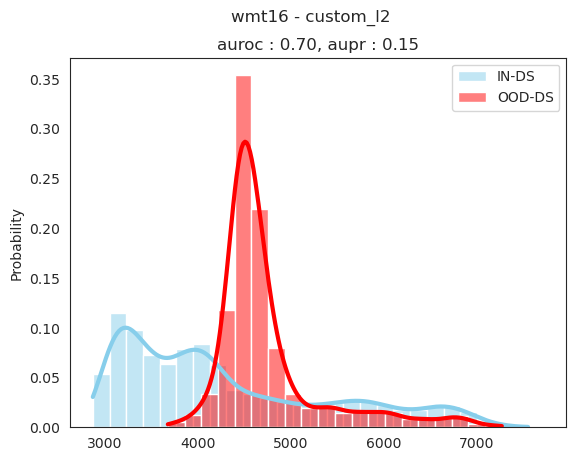

 Weighted mean [0.70285179 0.18562498]
Mean [0.70988265 0.18321077]


In [23]:
clf = OODDetector(
        similarity='custom_l2',
        base_distribution=embd_train,
        base_ood_distribution = ood_dict['sst2']['embd'],
        T=10,
        sampling_ratio=.05,
     ).fit() 

# Careful to change the attn/logits/embd according to the classifier

scores=[]
weights=[]
for ds_n,ood_ds in ood_dict.items():
    y_score_tot = []
    y_true_tot = []
    score_for_1__ds = []

    clf = clfs[i]
    y_true = np.concatenate((np.ones(ood_ds['embd'].shape[0]), np.zeros(embd_test.shape[0])))
    X = np.concatenate((ood_ds['embd'] ,embd_test))
    y_score = clf.predict_proba(X).flatten()
    auc_score = roc_auc_score(y_true=y_true, y_score=y_score)
    aupr = average_precision_score(y_true=y_true, y_score=y_score)
    scores.append([auc_score, aupr])
    weights.append(len(y_true))


    
    bins_width = (np.histogram(y_score[y_true==1])[1][3]-np.histogram(y_score[y_true==1])[1][2])/2
    sns.histplot(y_score[y_true==0], label='IN-DS', kde=True, stat='probability', color='skyblue', binwidth=bins_width, line_kws={"lw":3})
    sns.histplot(y_score[y_true==1], label='OOD-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3})
    _a = scores[-1]
    plt.title(f"auroc : {_a[0]:.2f}, aupr : {_a[1]:.2f}")

    plt.suptitle(ds_n + f' - {clfs[0].similarity}')
    plt.legend()
    plt.savefig(f'../figures/{clfs[0].similarity}_{ds_n}.png')
    plt.show()

scores, weights = np.array(scores), np.array(weights)/(np.sum(weights))
print(f" Weighted mean {scores.T@weights}")
print(f"Mean {np.mean(scores, axis=0)}")

## Grid Search 

In [ ]:
#import random search from sklearn
from sklearn.model_selection import RandomizedSearchCV
#import shuffle from sklearn
from sklearn.utils import shuffle

X_0, y_0 = shuffle(X_0, y_0)
X_1, y_1 = shuffle(X_1, y_1)
X_, y_ = shuffle(X_, y_)

# Create the parameter grid based on the results of random search, tau follows a gaussian centered in 50 with std 10
param_grid = {
    'tau': np.random.uniform(-150, 0, 100), 
    'similarity': ['mahalanobis'],
    'base_distribution' : [train_distrib[0]]
}

# Create a based model
clf = OODDetector(similarity='mahalanobis', tau=50, base_distribution=train_distrib[0])

# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = clf, param_distributions = param_grid,
                            cv = 5, n_jobs = -1, verbose = 0, scoring='balanced_accuracy')


In [ ]:
grid_search.fit(X_0, y_0)
print(grid_search.best_params_)

In [17]:
grid_search.best_score_

0.9770796974985456